In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import time 
from sklearn.metrics import mean_squared_error

'''
None || 20000 || 100000
'''
nb = None
nb_trains = nb
nb_valids = nb
nb_tests = nb

N_past = 10

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
cd drive/MyDrive/Projects/JPX_Tokyo_Stock/JPX_stock_2022/working

/content/drive/.shortcut-targets-by-id/1A94r5G8zPZL7lzjCyu52eNPwhrRQiNYp/Projects/JPX_Tokyo_Stock/JPX_stock_2022/working


In [4]:
! pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 8.4 MB/s 
     |████████████████████████████████| 81 kB 12.3 MB/s 
     |████████████████████████████████| 209 kB 72.0 MB/s 
     |████████████████████████████████| 78 kB 9.5 MB/s 
     |████████████████████████████████| 49 kB 7.5 MB/s 
     |████████████████████████████████| 147 kB 77.7 MB/s 
     |████████████████████████████████| 112 kB 75.4 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=4707f2fed861b3fbb96607856c09cee730860c9e899c6e733af6c25c28057685
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [5]:
import optuna
from data_utils import *

#### Load Data

In [6]:
train_df = pd.read_csv('../__input__/2_FeatureEngineering/train_df.csv', parse_dates=['Date'], nrows = nb_trains)
valid_df = pd.read_csv('../__input__/2_FeatureEngineering/valid_df.csv', parse_dates=['Date'], nrows = nb_trains)
test_df = pd.read_csv('../__input__/2_FeatureEngineering/test_df.csv', parse_dates=['Date'], nrows = nb_trains)

# hidden_test_df = pd.read_csv('../__input__/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv', nrows = None, parse_dates=['Date'])

In [7]:
mini_train_DP = pd.read_csv('../__input__/1_DataPreprocessing/mini_train.csv', parse_dates=['Date'], nrows = None)
mini_train_FE = pd.read_csv('../__input__/2_FeatureEngineering/mini_train.csv', parse_dates=['Date'], nrows = None)

In [8]:
# hidden_test_df = FeatureEngineering_for_hidden_test(DataPreprocessing_for_hidden_test(hidden_test_df, mini_train_after_dataPreprocessing), mini_train_after_featureEngineering, N_past)

In [9]:
def get_base_feature(df):
  return df[[
      'Date', 'SecuritiesCode', 'Volume', 'AdjustmentFactor', 'ExpectedDividend', 
      'SupervisionFlag', 'Range_HL', 'Range_OC','Close', 'Target', 'CloseT1', 'CloseT2'

    ]]

In [10]:
train_df = get_base_feature(train_df)
valid_df = get_base_feature(valid_df)
test_df = get_base_feature(test_df)
# hidden_test_df = get_base_feature(hidden_test_df, isTest = True)

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1843182 entries, 0 to 1843181
Data columns (total 12 columns):
 #   Column            Dtype         
---  ------            -----         
 0   Date              datetime64[ns]
 1   SecuritiesCode    int64         
 2   Volume            float64       
 3   AdjustmentFactor  float64       
 4   ExpectedDividend  float64       
 5   SupervisionFlag   bool          
 6   Range_HL          float64       
 7   Range_OC          float64       
 8   Close             float64       
 9   Target            float64       
 10  CloseT1           float64       
 11  CloseT2           float64       
dtypes: bool(1), datetime64[ns](1), float64(9), int64(1)
memory usage: 156.4 MB


In [12]:
valid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232663 entries, 0 to 232662
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              232663 non-null  datetime64[ns]
 1   SecuritiesCode    232663 non-null  int64         
 2   Volume            232663 non-null  float64       
 3   AdjustmentFactor  232663 non-null  float64       
 4   ExpectedDividend  232663 non-null  float64       
 5   SupervisionFlag   232663 non-null  bool          
 6   Range_HL          232663 non-null  float64       
 7   Range_OC          232663 non-null  float64       
 8   Close             232663 non-null  float64       
 9   Target            232663 non-null  float64       
 10  CloseT1           232663 non-null  float64       
 11  CloseT2           232663 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(9), int64(1)
memory usage: 19.7 MB


In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198663 entries, 0 to 198662
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Date              198663 non-null  datetime64[ns]
 1   SecuritiesCode    198663 non-null  int64         
 2   Volume            198663 non-null  float64       
 3   AdjustmentFactor  198663 non-null  float64       
 4   ExpectedDividend  198663 non-null  float64       
 5   SupervisionFlag   198663 non-null  bool          
 6   Range_HL          198663 non-null  float64       
 7   Range_OC          198663 non-null  float64       
 8   Close             198663 non-null  float64       
 9   Target            198663 non-null  float64       
 10  CloseT1           198663 non-null  float64       
 11  CloseT2           198663 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(9), int64(1)
memory usage: 16.9 MB


### Calc Scores

In [14]:
def calc_spread_return_per_day(df, portfolio_size: int = 200, toprank_weight_ratio: float = 2):
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): spread return
    """
    assert df['Rank'].min() == 0
    assert df['Rank'].max() == len(df['Rank']) - 1
    weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
    purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
    short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
    return purchase - short

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    buf = df.groupby('Date').apply(calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio, buf

def add_rank(df: pd.DataFrame, y_pred):
    df["Pred"] = y_pred
    df["Rank"] = df.groupby("Date")["Pred"].rank(ascending=False, method="first") - 1 
    df = df.drop("Pred", axis= 1)
    return df

In [15]:
def calc_score(df: pd.DataFrame, y_pred: pd.DataFrame, y_true: pd.DataFrame, render_info= True):
    feature_df = df.copy()
    feature_df = add_rank(feature_df, y_pred)
    feature_df['Target'] = y_true
    score, buf = calc_spread_return_sharpe(feature_df)
    if render_info:
        print(f'score -> {score}\nmean -> {buf.mean()}\nstd -> {buf.std()}')
    del feature_df
    return score

In [16]:
calc_score(test_df, test_df["Target"], test_df["Target"])

score -> 4.7366694709759
mean -> 15.115996128121251
std -> 3.1912710440838277


4.7366694709759

### Cross Validation

In [17]:
featureCols = train_df.drop(["Target", "CloseT1", "CloseT2"], axis = 1).columns
featureCols

Index(['Date', 'SecuritiesCode', 'Volume', 'AdjustmentFactor',
       'ExpectedDividend', 'SupervisionFlag', 'Range_HL', 'Range_OC', 'Close'],
      dtype='object')

In [18]:
X_train = train_df[featureCols]
X_train["Date"] = X_train["Date"].astype(str)
y_train = train_df["Target"]

X_valid = valid_df[featureCols]
X_valid["Date"] = X_valid["Date"].astype(str)
y_valid = valid_df["Target"]

X_test = test_df[featureCols]
X_test["Date"] = X_test["Date"].astype(str)
yTest_true = test_df["Target"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [19]:
calc_score(X_test, yTest_true, yTest_true)

score -> 4.7366694709759
mean -> 15.115996128121251
std -> 3.1912710440838277


4.7366694709759

#### Optuna tuning

In [20]:
def objective(
    trial,
    random_state=22,
    n_jobs=-1,
):
    # XGBoost parameters
    params = {
        'tree_method':'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 5, 10) * 100,
        "max_depth": trial.suggest_int("max_depth", 4, 20),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.05),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.6),
        "subsample": trial.suggest_loguniform("subsample", 0.6, 0.8),
        "alpha": trial.suggest_loguniform("alpha", 0.01, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "gamma": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 10, 1000),
        "seed": random_state,
        "n_jobs": n_jobs,
        "early_stopping_rounds": 50,
        "eval_metric": "rmse"
        
    }
    
    model = xgb.XGBRegressor(**params) 

    model.fit(
        X_train.drop("Date", axis = 1),
        y_train,
        eval_set=[(X_valid.drop("Date", axis = 1), y_valid)],
        verbose=0,
    )
    y_pred = pd.DataFrame(model.predict(X_valid.drop("Date", axis = 1)), columns =['Target'])
    return calc_score(X_valid, y_pred, y_valid, render_info= False)

In [21]:
%%time
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-07-19 16:43:27,562] A new study created in memory with name: no-name-e0a18a85-64ec-465f-8e57-d5247466b150
[I 2022-07-19 16:43:44,744] Trial 0 finished with value: 0.2109143386920176 and parameters: {'n_estimators': 6, 'max_depth': 9, 'learning_rate': 0.013245662301797656, 'colsample_bytree': 0.28835022953820905, 'subsample': 0.661964236518163, 'alpha': 0.03244209303603696, 'lambda': 0.020609529010972665, 'min_child_weight': 153.91569483565414}. Best is trial 0 with value: 0.2109143386920176.
[I 2022-07-19 16:44:45,915] Trial 1 finished with value: 0.22385102933845374 and parameters: {'n_estimators': 9, 'max_depth': 19, 'learning_rate': 0.012397841927839413, 'colsample_bytree': 0.36693244270191444, 'subsample': 0.7729123589958729, 'alpha': 0.017655155171722784, 'lambda': 6.192959849952802e-05, 'min_child_weight': 364.92989805933615}. Best is trial 1 with value: 0.22385102933845374.
[I 2022-07-19 16:45:14,288] Trial 2 finished with value: 0.2026045564684057 and parameters: {'n_es

Number of finished trials: 30
Best trial: {'n_estimators': 8, 'max_depth': 7, 'learning_rate': 0.04944909964793068, 'colsample_bytree': 0.3925760075873685, 'subsample': 0.6293537781041777, 'alpha': 0.12643483794818983, 'lambda': 0.6700813104926183, 'min_child_weight': 95.00548848927907}
CPU times: user 16min 37s, sys: 9.64 s, total: 16min 47s
Wall time: 16min 45s


In [22]:
best_params = {'alpha': 6.136534344576318,
 'colsample_bytree': 0.4556890651072459,
 'early_stopping_rounds': 50,
 'eval_metric': 'rmse',
 'lambda': 2.974806182643934e-05,
 'learning_rate': 0.009285584993060795,
 'max_depth': 9,
 'min_child_weight': 52.49623817912228,
 'n_estimators': 1000,
 'n_jobs': -1,
 'objective': 'reg:squarederror',
 'seed': 22,
 'subsample': 0.642007145011998,
 'tree_method': 'gpu_hist',
 'verbosity': 0}

In [23]:
# best_params = study.best_trial.params
# best_params['n_estimators'] *= 100

# best_params['tree_method'] = 'gpu_hist'
# best_params['verbosity'] = 0
# best_params['objective'] = "reg:squarederror"
# best_params['seed'] = 22
# best_params['n_jobs'] = -1
# best_params["early_stopping_rounds"] = 50
# best_params["eval_metric"] = "rmse"

# best_params

In [24]:
%%time
model = xgb.XGBRegressor(**best_params) 

model.fit(
    X_train.drop("Date", axis = 1),
    y_train,
    eval_set=[(X_valid.drop("Date", axis = 1), y_valid)],
    verbose=0,
)

CPU times: user 25.3 s, sys: 280 ms, total: 25.6 s
Wall time: 25.6 s


In [25]:
%%time
y_pred = pd.DataFrame(model.predict(X_train.drop("Date", axis = 1)), columns =['Target'])
print(calc_score(X_train, y_pred, y_train, render_info= False))

0.9524972443253361
CPU times: user 4.14 s, sys: 200 ms, total: 4.34 s
Wall time: 4.32 s


In [26]:
np.sqrt(mean_squared_error(y_pred, y_train))

0.023194944721887413

In [27]:
%%time
y_pred = pd.DataFrame(model.predict(X_valid.drop("Date", axis = 1)), columns =['Target'])
print(calc_score(X_valid, y_pred, y_valid, render_info= False))

0.2540521421530262
CPU times: user 574 ms, sys: 19 ms, total: 594 ms
Wall time: 591 ms


In [28]:
np.sqrt(mean_squared_error(y_pred, y_valid))

0.021142343945678696

In [29]:
%%time
y_pred = pd.DataFrame(model.predict(X_test.drop("Date", axis = 1)), columns =['Target'])
print(calc_score(X_test, y_pred, yTest_true, render_info= False))

-0.037918221997563964
CPU times: user 478 ms, sys: 13 ms, total: 491 ms
Wall time: 495 ms


In [30]:
np.sqrt(mean_squared_error(y_pred, yTest_true))

0.02404411398540253

In [31]:
def render_feature_important(model_xgboost, df_trained):
  feature_important = model.feature_importances_
  sorted_idx = np.argsort(feature_important)[::-1]

  keys = df_trained.columns[sorted_idx]
  values = feature_important[sorted_idx]

  data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
  data.plot(kind='barh', figsize = (20,10))

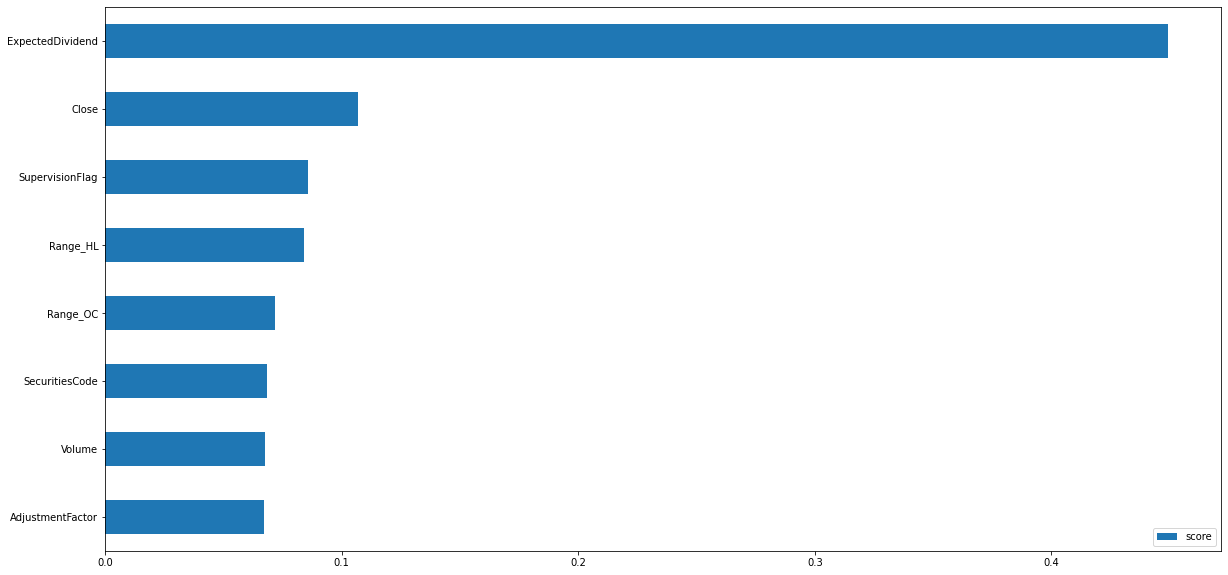

In [32]:
render_feature_important(model, X_train.drop("Date", axis = 1))